In [856]:
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

data = pd.read_csv('D:\Hutson\learning-materials\AI_ML\AIMLDLCV_advance\Class\Datasets\Time-series-datasets\electricity.csv')
data.head()

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.83,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.37,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.97,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.56,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.23,20.40,2012-01-01,True


In [857]:
data = data[['Demand', 'Temperature', 'Date', 'Holiday']].groupby(['Date', 'Holiday']).agg(total_demand=('Demand', 'sum'), 
                                                                                           avg_temperature=('Temperature', 'mean')).reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data.head()


,Date,Holiday,total_demand,avg_temperature
0,2012-01-01,True,222437.91,25.32
1,2012-01-02,True,257964.72,30.69
2,2012-01-03,False,267098.61,26.51
3,2012-01-04,False,222742.29,21.00
4,2012-01-05,False,210585.24,17.52


In [858]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1096 non-null   datetime64[ns]
 1   Holiday          1096 non-null   bool          
 2   total_demand     1096 non-null   float64       
 3   avg_temperature  1096 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(2)
memory usage: 26.9 KB


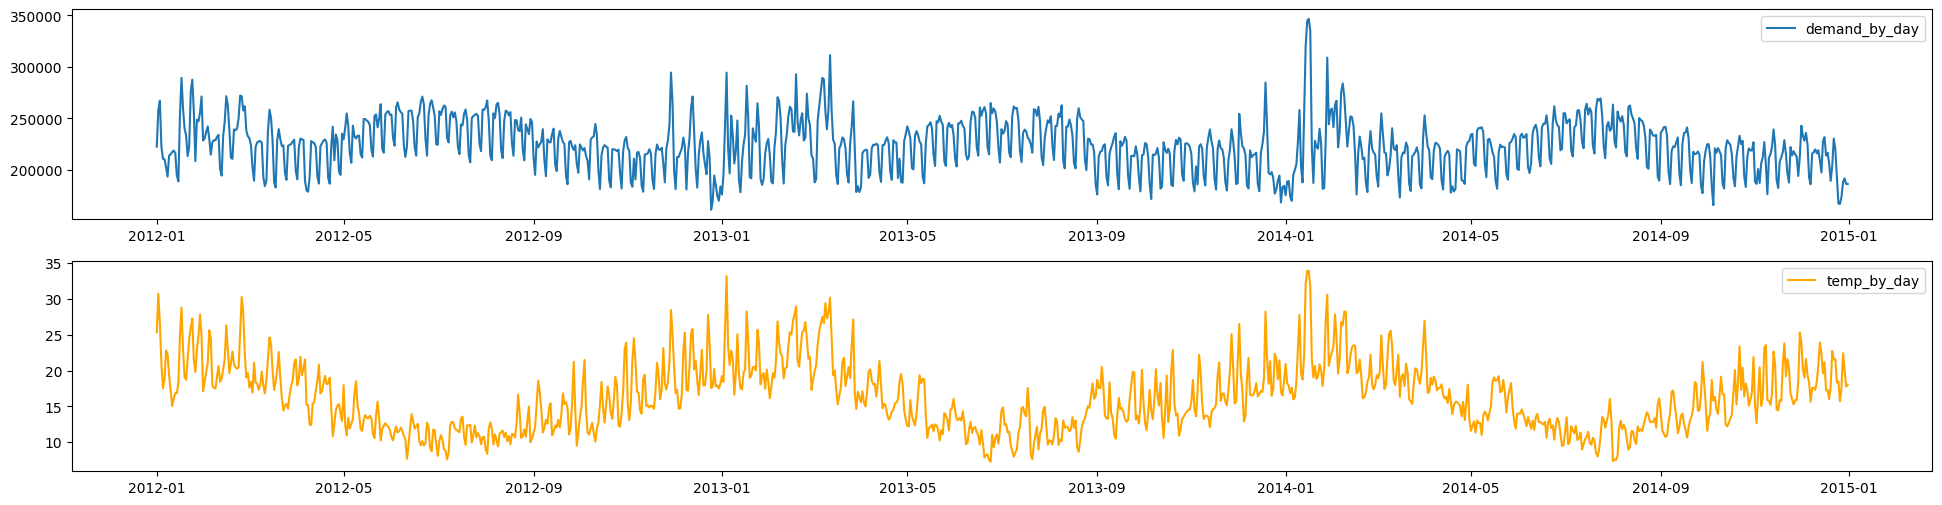

In [859]:
fig, axs = plt.subplots(2, figsize = (24,6))
axs[0].plot(data['Date'],data['total_demand'], label = 'demand_by_day')
axs[1].plot(data['Date'],data['avg_temperature'], label = 'temp_by_day',color='orange')
axs[0].legend()
axs[1].legend()
plt.show()

In [860]:
data.tail(10)

,Date,Holiday,total_demand,avg_temperature
1086,2014-12-22,False,230291.01,21.54
1087,2014-12-23,False,219995.40,21.59
1088,2014-12-24,False,193189.41,18.33
1089,2014-12-25,True,167042.09,18.47
1090,2014-12-26,True,166733.90,15.70
1091,2014-12-27,False,173634.64,17.58
1092,2014-12-28,False,188115.34,22.41
1093,2014-12-29,False,191596.32,20.04
1094,2014-12-30,False,186100.91,17.77
1095,2014-12-31,False,186198.47,18.03


In [861]:
data['total_demand_(-1)'] = data['total_demand'].shift(1)
data.tail(10)

,Date,Holiday,total_demand,avg_temperature,total_demand_(-1)
1086,2014-12-22,False,230291.01,21.54,203713.44
1087,2014-12-23,False,219995.40,21.59,230291.01
1088,2014-12-24,False,193189.41,18.33,219995.40
1089,2014-12-25,True,167042.09,18.47,193189.41
1090,2014-12-26,True,166733.90,15.70,167042.09
1091,2014-12-27,False,173634.64,17.58,166733.90
1092,2014-12-28,False,188115.34,22.41,173634.64
1093,2014-12-29,False,191596.32,20.04,188115.34
1094,2014-12-30,False,186100.91,17.77,191596.32
1095,2014-12-31,False,186198.47,18.03,186100.91


In [862]:
def create_recursive_data(data, window_size):

    i = 1
    while i <= window_size:
        data['total_demand_(-{})'.format(i)] = data['total_demand'].shift(i)
        data['avg_temperature_(-{})'.format(i)] = data['avg_temperature'].shift(i)
        i+=1
    # data.drop(['Date','avg_temperature'], axis = 1, inplace=True)
    data.dropna(inplace=True)
    return data

In [863]:
window_size = 50
recursive_data = create_recursive_data(data, window_size)
recursive_data

,Date,Holiday,total_demand,avg_temperature,total_demand_(-1),avg_temperature_(-1),total_demand_(-2),avg_temperature_(-2),total_demand_(-3),avg_temperature_(-3),...,total_demand_(-46),avg_temperature_(-46),total_demand_(-47),avg_temperature_(-47),total_demand_(-48),avg_temperature_(-48),total_demand_(-49),avg_temperature_(-49),total_demand_(-50),avg_temperature_(-50)
50,2012-02-20,False,239208.05,20.90,210570.17,22.64,211657.35,21.02,238790.73,19.64,...,210585.24,17.52,222742.29,21.00,267098.61,26.51,257964.72,30.69,222437.91,25.32
51,2012-02-21,False,238433.94,20.44,239208.05,20.90,210570.17,22.64,211657.35,21.02,...,210246.54,18.69,210585.24,17.52,222742.29,21.00,267098.61,26.51,257964.72,30.69
52,2012-02-22,False,239938.66,20.27,238433.94,20.44,239208.05,20.90,210570.17,22.64,...,202526.30,22.80,210246.54,18.69,210585.24,17.52,222742.29,21.00,267098.61,26.51
53,2012-02-23,False,250064.76,20.42,239938.66,20.27,238433.94,20.44,239208.05,20.90,...,193412.53,22.27,202526.30,22.80,210246.54,18.69,210585.24,17.52,222742.29,21.00
54,2012-02-24,False,272114.55,25.23,250064.76,20.42,239938.66,20.27,238433.94,20.44,...,213803.97,19.29,193412.53,22.27,202526.30,22.80,210246.54,18.69,210585.24,17.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2014-12-27,False,173634.64,17.58,166733.90,15.70,167042.09,18.47,193189.41,18.33,...,215166.37,15.20,211403.75,15.80,176249.66,15.88,205990.87,23.55,226861.38,23.15
1092,2014-12-28,False,188115.34,22.41,173634.64,17.58,166733.90,15.70,167042.09,18.47,...,222218.28,16.81,215166.37,15.20,211403.75,15.80,176249.66,15.88,205990.87,23.55
1093,2014-12-29,False,191596.32,20.04,188115.34,22.41,173634.64,17.58,166733.90,15.70,...,239191.25,22.64,222218.28,16.81,215166.37,15.20,211403.75,15.80,176249.66,15.88
1094,2014-12-30,False,186100.91,17.77,191596.32,20.04,188115.34,22.41,173634.64,17.58,...,224297.71,20.84,239191.25,22.64,222218.28,16.81,215166.37,15.20,211403.75,15.80


In [864]:
data

,Date,Holiday,total_demand,avg_temperature,total_demand_(-1),avg_temperature_(-1),total_demand_(-2),avg_temperature_(-2),total_demand_(-3),avg_temperature_(-3),...,total_demand_(-46),avg_temperature_(-46),total_demand_(-47),avg_temperature_(-47),total_demand_(-48),avg_temperature_(-48),total_demand_(-49),avg_temperature_(-49),total_demand_(-50),avg_temperature_(-50)
50,2012-02-20,False,239208.05,20.90,210570.17,22.64,211657.35,21.02,238790.73,19.64,...,210585.24,17.52,222742.29,21.00,267098.61,26.51,257964.72,30.69,222437.91,25.32
51,2012-02-21,False,238433.94,20.44,239208.05,20.90,210570.17,22.64,211657.35,21.02,...,210246.54,18.69,210585.24,17.52,222742.29,21.00,267098.61,26.51,257964.72,30.69
52,2012-02-22,False,239938.66,20.27,238433.94,20.44,239208.05,20.90,210570.17,22.64,...,202526.30,22.80,210246.54,18.69,210585.24,17.52,222742.29,21.00,267098.61,26.51
53,2012-02-23,False,250064.76,20.42,239938.66,20.27,238433.94,20.44,239208.05,20.90,...,193412.53,22.27,202526.30,22.80,210246.54,18.69,210585.24,17.52,222742.29,21.00
54,2012-02-24,False,272114.55,25.23,250064.76,20.42,239938.66,20.27,238433.94,20.44,...,213803.97,19.29,193412.53,22.27,202526.30,22.80,210246.54,18.69,210585.24,17.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2014-12-27,False,173634.64,17.58,166733.90,15.70,167042.09,18.47,193189.41,18.33,...,215166.37,15.20,211403.75,15.80,176249.66,15.88,205990.87,23.55,226861.38,23.15
1092,2014-12-28,False,188115.34,22.41,173634.64,17.58,166733.90,15.70,167042.09,18.47,...,222218.28,16.81,215166.37,15.20,211403.75,15.80,176249.66,15.88,205990.87,23.55
1093,2014-12-29,False,191596.32,20.04,188115.34,22.41,173634.64,17.58,166733.90,15.70,...,239191.25,22.64,222218.28,16.81,215166.37,15.20,211403.75,15.80,176249.66,15.88
1094,2014-12-30,False,186100.91,17.77,191596.32,20.04,188115.34,22.41,173634.64,17.58,...,224297.71,20.84,239191.25,22.64,222218.28,16.81,215166.37,15.20,211403.75,15.80


In [865]:
test_size = 0.2
target = 'total_demand'
x_train = recursive_data.drop(['Date','avg_temperature',target] , axis =1)[:int(len(recursive_data)*(1-test_size))]
x_test = recursive_data.drop(['Date','avg_temperature',target] , axis =1)[int(len(recursive_data)*(1-test_size)):]
y_train = recursive_data[target][:int(len(recursive_data)*(1-test_size))]
y_test = recursive_data[target][int(len(recursive_data)*(1-test_size)):]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(836, 101) (836,) (210, 101) (210,)


In [866]:
# from lazypredict.Supervised import LazyRegressor
# from sklearn import datasets
# from sklearn.utils import shuffle
# import numpy as np


# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(x_train, x_test, y_train, y_test)

# print(models)

In [867]:
params = {
    "max_iter": [100, 50, 80, 400, 500],
    "alpha": [0.0001, 0.0002, 0.0008, 0.0009, 0.001],
}

model = RandomizedSearchCV(HuberRegressor(), param_distributions=params, cv=5, n_jobs=-1,verbose=2, scoring='r2', n_iter=25, random_state=42)

model.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=HuberRegressor(), n_iter=25, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.0002, 0.0008,
                                                  0.0009, 0.001],
                                        'max_iter': [100, 50, 80, 400, 500]},
                   random_state=42, scoring='r2', verbose=2)

In [868]:
print(model.best_params_)
print(model.best_score_)

{'max_iter': 400, 'alpha': 0.0009}
0.7045715743961717


In [878]:
y_predict = model.predict(x_test)
for i, j in zip(y_pred, y_test):
    print("Predicted: ", i, "Actual: ", j)

Predicted:  236925.02859391924 Actual:  232087.479466
Predicted:  219587.5328923302 Actual:  234671.5011
Predicted:  228103.31801812796 Actual:  202432.333296
Predicted:  230312.0719444958 Actual:  196719.661858
Predicted:  227807.4700416346 Actual:  206504.624442
Predicted:  204956.31005950837 Actual:  235778.186192
Predicted:  217319.46820685358 Actual:  241099.380104
Predicted:  238936.55228260256 Actual:  243616.722524
Predicted:  225878.967700744 Actual:  237212.577078
Predicted:  227943.3800162773 Actual:  212136.561988
Predicted:  230950.26986620974 Actual:  203358.19459
Predicted:  231925.6789010397 Actual:  241320.649452
Predicted:  204077.3186596874 Actual:  244756.767862
Predicted:  196618.3893290816 Actual:  244588.34475
Predicted:  218020.61277569548 Actual:  252897.449834
Predicted:  238200.5605995847 Actual:  239694.76055
Predicted:  231202.6771201284 Actual:  211049.436444
Predicted:  237405.85726792083 Actual:  205688.831308
Predicted:  232127.12636120038 Actual:  2453

In [874]:
zip(y_predict, y_test)

In [870]:
print("MAE: {}".format(mean_absolute_error(y_test, y_predict)))
print("MSE: {}".format(mean_squared_error(y_test, y_predict)))
print("R2: {}".format(r2_score(y_test, y_predict)))

MAE: 6300.909165836059
MSE: 72098554.22442521
R2: 0.8632667009618922


In [871]:
data

,Date,Holiday,total_demand,avg_temperature,total_demand_(-1),avg_temperature_(-1),total_demand_(-2),avg_temperature_(-2),total_demand_(-3),avg_temperature_(-3),...,total_demand_(-46),avg_temperature_(-46),total_demand_(-47),avg_temperature_(-47),total_demand_(-48),avg_temperature_(-48),total_demand_(-49),avg_temperature_(-49),total_demand_(-50),avg_temperature_(-50)
50,2012-02-20,False,239208.05,20.90,210570.17,22.64,211657.35,21.02,238790.73,19.64,...,210585.24,17.52,222742.29,21.00,267098.61,26.51,257964.72,30.69,222437.91,25.32
51,2012-02-21,False,238433.94,20.44,239208.05,20.90,210570.17,22.64,211657.35,21.02,...,210246.54,18.69,210585.24,17.52,222742.29,21.00,267098.61,26.51,257964.72,30.69
52,2012-02-22,False,239938.66,20.27,238433.94,20.44,239208.05,20.90,210570.17,22.64,...,202526.30,22.80,210246.54,18.69,210585.24,17.52,222742.29,21.00,267098.61,26.51
53,2012-02-23,False,250064.76,20.42,239938.66,20.27,238433.94,20.44,239208.05,20.90,...,193412.53,22.27,202526.30,22.80,210246.54,18.69,210585.24,17.52,222742.29,21.00
54,2012-02-24,False,272114.55,25.23,250064.76,20.42,239938.66,20.27,238433.94,20.44,...,213803.97,19.29,193412.53,22.27,202526.30,22.80,210246.54,18.69,210585.24,17.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2014-12-27,False,173634.64,17.58,166733.90,15.70,167042.09,18.47,193189.41,18.33,...,215166.37,15.20,211403.75,15.80,176249.66,15.88,205990.87,23.55,226861.38,23.15
1092,2014-12-28,False,188115.34,22.41,173634.64,17.58,166733.90,15.70,167042.09,18.47,...,222218.28,16.81,215166.37,15.20,211403.75,15.80,176249.66,15.88,205990.87,23.55
1093,2014-12-29,False,191596.32,20.04,188115.34,22.41,173634.64,17.58,166733.90,15.70,...,239191.25,22.64,222218.28,16.81,215166.37,15.20,211403.75,15.80,176249.66,15.88
1094,2014-12-30,False,186100.91,17.77,191596.32,20.04,188115.34,22.41,173634.64,17.58,...,224297.71,20.84,239191.25,22.64,222218.28,16.81,215166.37,15.20,211403.75,15.80


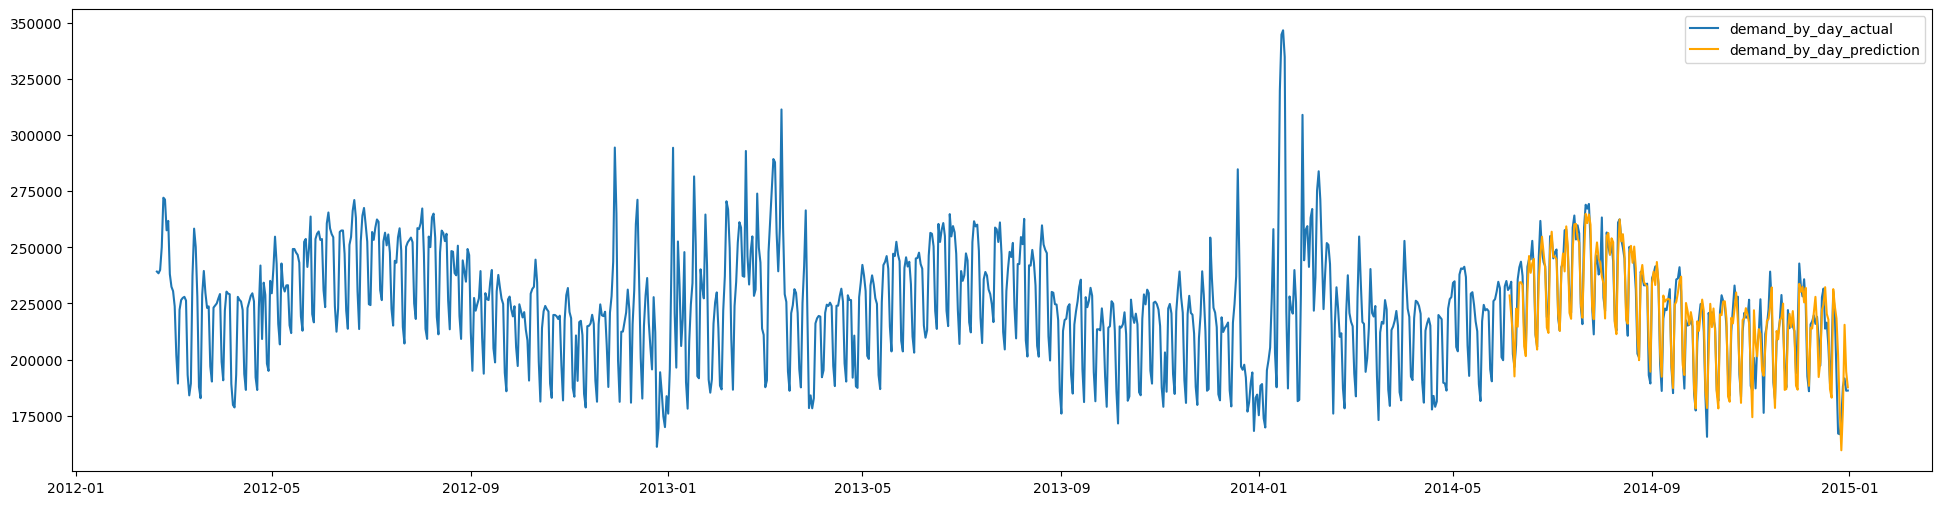

In [879]:
fig, axs = plt.subplots(figsize = (24,6))
axs.plot(data['Date'],data['total_demand'], label = 'demand_by_day_actual')
axs.plot(data['Date'][int(len(recursive_data)*(1-test_size)):],y_predict, label = 'demand_by_day_prediction',color='orange')
axs.legend()
plt.show()